In [101]:
# prvotni import

import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import sys
from numpy import pi
from typing import Tuple, Dict
sys.path.append('..')

In [102]:
# vlastni import
from src import train, utils
from src import calculus as calc
import src.data.cube_domain as cb
from src.models.mlp_model import MLPModel

In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
# konstanty (parametry problemu)
ALPHA = 1.14
A = 2
B = 2
T_MAX = 1

In [106]:
l_bounds = [0, 0, 0]
u_bounds = [A, B, T_MAX]

plot_ctx = utils.PlotContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    patches=[],
    colour_map='inferno',
    vmin=-3,
    vmax=4,
    device=device,
    N=100
)

In [107]:
def initial_condition(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) - 3 * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B)

def analytical_solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) * torch.exp(-ALPHA * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2)) +\
           (-3) * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B) * torch.exp(-ALPHA * 25 * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2))

In [ ]:
# moznost dale rozvijet tento zpusob sbirani loss?

pde_loss_values = []
initial_loss_values = []
boundary_loss_values = []
iteration = 0

def pde_residuum(pde_input: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    # PDE ztrata:
    pde_output = model(pde_input)
    u_t = grad(pde_output, pde_input, torch.ones_like(pde_output), create_graph=True)[0][:, -1:]
    laplacian = calc.laplacian(pde_input, pde_output, device=device)
    return u_t - ALPHA * laplacian

first_iteration = True
temp_init_condition = lambda x: initial_condition(x)

def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    # PDE ztrata:
    pde_input = domain.interior.requires_grad_(True)
    pde_res = pde_residuum(pde_input, model)
    pde_loss = torch.mean((pde_res)**2)
    
    # ztrata na hranicich:
    side_input = domain.get_side_points(2).requires_grad_(True)
    side_output = model(side_input)
    side_loss = torch.mean(side_output**2)
    
    # ztrata na pocatku
    initial_input = domain.sides[-1][0].requires_grad_(True)
    init_output = model(initial_input)
    init_values = temp_init_condition(initial_input)
    init_loss = torch.mean((init_output - init_values)**2)

    # valid???
    global iteration
    if iteration % 100 == 99:
        pde_loss_values.append(pde_loss.item())
        boundary_loss_values.append(side_loss.item())
        initial_loss_values.append(init_loss.item())

    iteration += 1
    return pde_loss + side_loss + 1000 * init_loss


In [109]:
# priprava modelu
model_time_dict: Dict[torch.nn.Module, Tuple] = {
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0, 0.2),
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0.2, 0.4),
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0.4, 0.6),
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0.6, 0.8),
    MLPModel(3, 1, [64, 64, 64], l_bounds, u_bounds).to(device) : (0.8, 1.0),
}

In [110]:
# definice domeny
domain_ctx = cb.CubeContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    dim=3,
    N_int=2_000,
    N_sides=[(100, 100), (100, 100), (1_000, 100)],
    device=device
)

domain = cb.CubeDomain(domain_ctx)

In [ ]:
train_ctx = train.TrainingContext(
    domain=domain,
    epochs=5_000,
    loss_fn=loss_fn,
    monitor_lr=True,
    monitor_gradient=True
)

loss_values = []

for i, (model, time) in enumerate(model_time_dict.items()):
    train_ctx.model = model
    train_ctx.optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
    train_ctx.scheduler = ReduceLROnPlateau(train_ctx.optimizer, factor=0.75, patience=200)

    domain.ctx.l_bounds[-1] = time[0]
    domain.ctx.u_bounds[-1] = time[1]

    loss_values += train.train_switch_to_lbfgs(train_ctx, lbfgs_lr=0.1)
    prev_model = model
    temp_init_condition = lambda x: prev_model(x)

Loss at epoch 1 is: 2501.809814453125. Total gradient norm: 1169.7635351618187 Current learing rate: 0.004 
Loss at epoch 100 is: 2157.397705078125. Total gradient norm: 800.4589880629668 Current learing rate: 0.004 
Loss at epoch 200 is: 2227.058349609375. Total gradient norm: 82.50345701676527 Current learing rate: 0.004 
Loss at epoch 300 is: 1944.3221435546875. Total gradient norm: 2113.9546557747963 Current learing rate: 0.004 
Loss at epoch 400 is: 1771.9124755859375. Total gradient norm: 829.7623548995674 Current learing rate: 0.004 
Loss at epoch 500 is: 1302.8203125. Total gradient norm: 6576.710054569924 Current learing rate: 0.004 
Loss at epoch 600 is: 802.2079467773438. Total gradient norm: 11425.39621566168 Current learing rate: 0.004 
Loss at epoch 700 is: 723.3818359375. Total gradient norm: 3895.5820566300304 Current learing rate: 0.004 
Loss at epoch 800 is: 596.8487548828125. Total gradient norm: 14923.030123191367 Current learing rate: 0.004 
Loss at epoch 900 is: 5

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


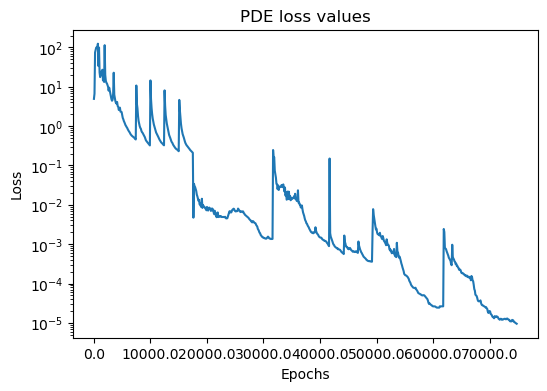

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


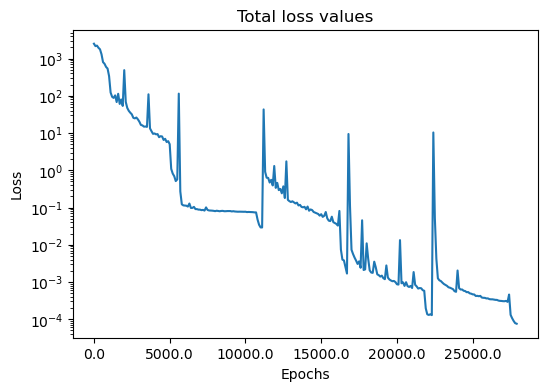

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


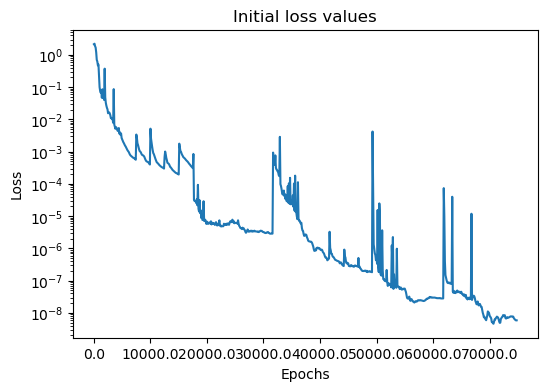

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


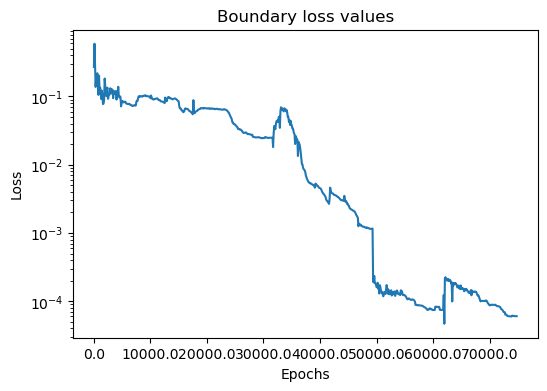

In [115]:
#initial_loss_values = [val.item() for val in initial_loss_values]

utils.plot_loss_values(pde_loss_values, 'Epochs', 'Loss', 'PDE loss values')
utils.plot_loss_values(loss_values, 'Epochs', 'Loss', 'Total loss values')
utils.plot_loss_values(initial_loss_values, 'Epochs', 'Loss', 'Initial loss values')
utils.plot_loss_values(boundary_loss_values, 'Epochs', 'Loss', 'Boundary loss values')

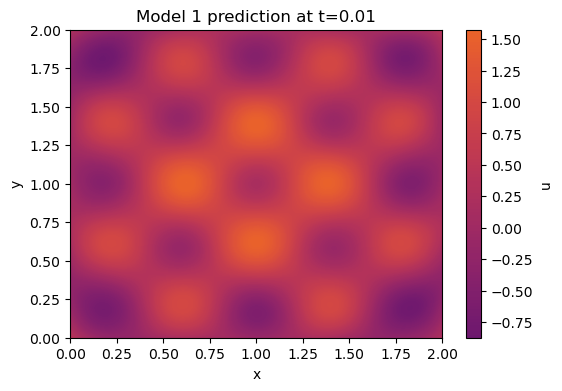

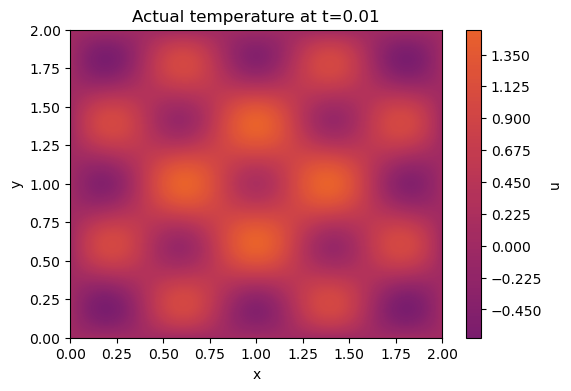

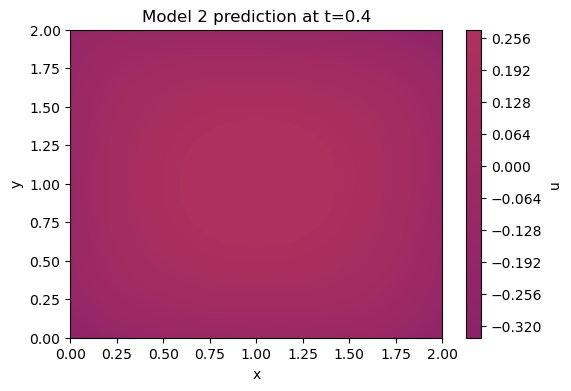

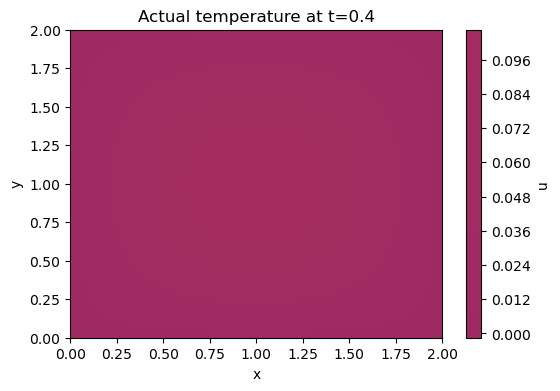

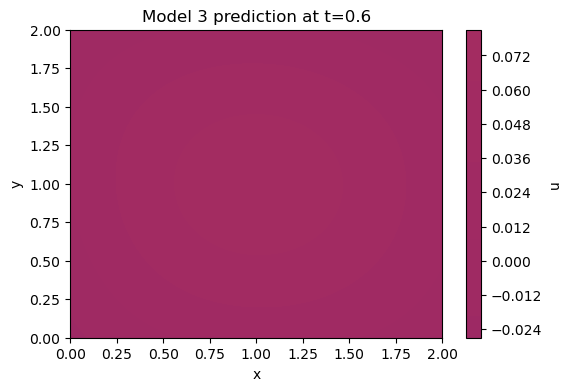

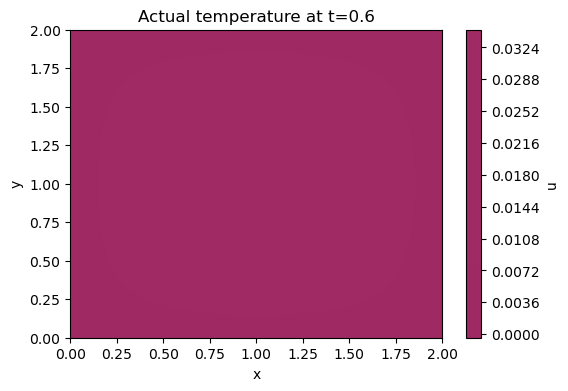

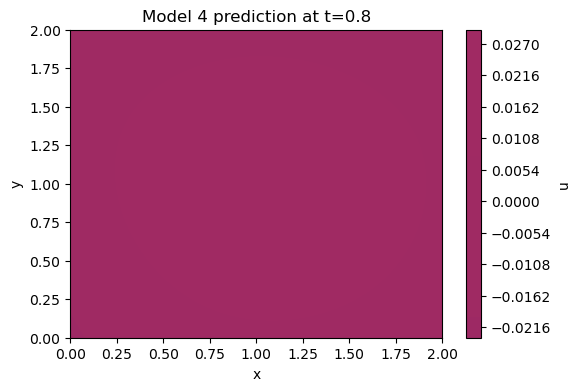

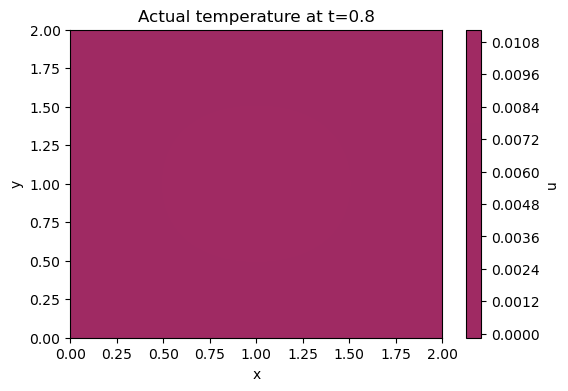

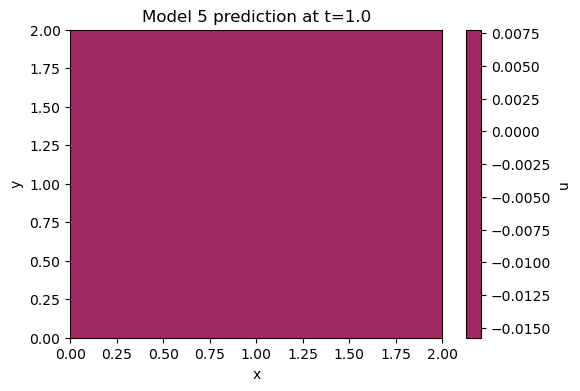

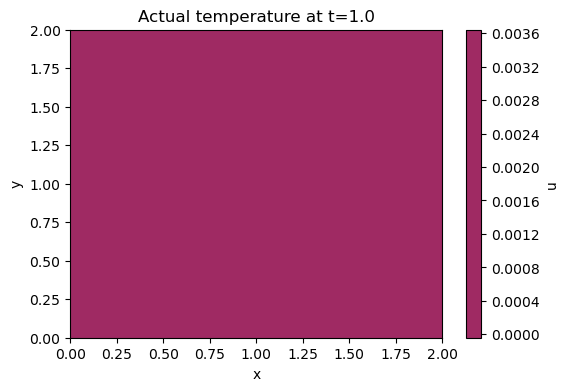

In [121]:
time_stamps = [0.01, 0.4, 0.6, 0.8, 1.0]

for i, model in enumerate(model_time_dict.keys()):
    plot_ctx.title = f'Model {i + 1} prediction at t={time_stamps[i]}'
    utils.plot_function_on_2d_cube(plot_ctx=plot_ctx, 
        function=lambda x: model(torch.cat( [x, torch.full( (x.shape[0], 1), time_stamps[i], device=device)], dim=1))
    )
    plot_ctx.title = f'Actual temperature at t={time_stamps[i]}'
    utils.plot_function_on_2d_cube(plot_ctx=plot_ctx, 
        function=lambda x: analytical_solution(torch.cat( [x, torch.full( (x.shape[0], 1), time_stamps[i], device=device)], dim=1))
    )

In [117]:
# A spocteme L2 chybu
torch.cuda.empty_cache()
l2_error = 0

for i, (model, time) in enumerate(model_time_dict.items()):
    partial_l2_error = calc.L2_norm(analytical_solution, model, 3, [2, 2, time[1]], [0, 0, time[0]], device=device, n=50)**2
    l2_error += partial_l2_error
    print(f'L2 chyba modelu {i + 1} je {torch.sqrt(partial_l2_error)}')

print(f"Celkova L2 chyba reseni je {torch.sqrt(l2_error)}")

L2 chyba modelu 1 je 0.1260867565870285
L2 chyba modelu 2 je 0.14743970334529877
L2 chyba modelu 3 je 0.04492383450269699
L2 chyba modelu 4 je 0.015462526120245457
L2 chyba modelu 5 je 0.005595587659627199
Celkova L2 chyba reseni je 0.1998121291399002
